In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization,LeakyReLU

2.7.0


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteC5LD57/fashion_mnist-train.tfrecord


  0%|          | 0/60000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteC5LD57/fashion_mnist-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.
[['Pullover' 'Trouser' 'Bag' 'Coat' 'Trouser']
 ['Ankle boot' 'Pullover' 'Pullover' 'T-shirt/top' 'Pullover']
 ['Shirt' 'Ankle boot' 'T-shirt/top' 'Sneaker' 'Sandal']
 ['Coat' 'T-shirt/top' 'Trouser' 'Bag' 'T-shirt/top']
 ['Coat' 'Pullover' 'Shirt' 'Sneaker' 'T-shirt/top']]


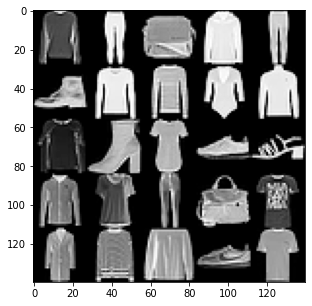

In [4]:
import tensorflow_datasets as tfds

data_train = tfds.load(name="fashion_mnist", split="train").prefetch(60000).cache()
data_test  = tfds.load(name="fashion_mnist", split="test" ).prefetch(10000).cache()

# Array for decoding the categories
label_names = np.array(['T-shirt/top',
                        'Trouser',
                        'Pullover',
                        'Dress',
                        'Coat',
                        'Sandal',
                        'Shirt',
                        'Sneaker',
                        'Bag',
                        'Ankle boot'])

# Get a single data batch of 25 images
sample_data = next(iter(data_train.batch(25)))
sample_images = sample_data['image']
sample_labels = sample_data['label']

# Plot the images in a 5x5 grid
plt.figure(figsize=(5, 5))
plt.imshow(
    sample_images.numpy().reshape(5, 5, 28, 28).transpose((0, 2, 1, 3)).reshape(140, 140),
    cmap='gray'
)
# Print corresponding labels
print(label_names[sample_labels.numpy().reshape(5, 5)])

# Task 1 (5 points + 1 point for the short comment)

Fill the gaps below to build a convolutional neural network and classify the images. Write a short comment on the validation metric images that you should obtain in the last cell.

Some hints for classes:
 - `tf.keras.layers.Conv2D` - convolutional layer
 - `tf.keras.layers.MaxPool2D` - maxpool layer
 - `tf.keras.layers.BatchNormalization` - batchnorm layer
 - `tf.keras.layers.Dropout` - dropout layer
 - `tf.keras.layers.Reshape` - reshaping layer (to convert the image-like representation to a vector-like representation deep down in the network

Try to follow the general deep convolutional architecture:
 - combine convolutions with maxpoolings to reduce the spacial size of the representation
 - increase the number of filters as you go deeper
 - when the spacial size of your representation is small enough (1-2 pixels), convert (reshape) it to a vector and then use fully connected layers

As you do this task, try to answer the following questions to yourself:
 - should I place batchnorm before or after the activation function?
  - (to answer this one, think how inactive neurons would affect the batchnorm statistics)
 - should I add dropout before or after batchnorm?
  - (think how batchnorm and dropout might interfere)
 - do I need an activation for the output layer?
  - (check the loss function used)
 - does it make sense to add a dropout to the output layer?
  - (common sense)
 - is it a good idea to add a batchnorm to the output layer?
  - (in fact, I don't have a good answer to this one, but imo a batchnorm in the last layer might lead to weird effects)

In [51]:
def build_model(use_batchnorm=False, dropout_rate=0.):
  """
  Fill in the layers below.

  If use_batchnorm is True, add a batchnorm layer to **every** convolution and
  dense layer (except for the output one).
  If dropout_rate > 0, add a dropout layer with `rate=dropout_rate` to **every**
  convolution and dense layer (except for the output one).
  """
  layers = []

  layers.append(Conv2D(32, (3, 3), activation='relu',
                       kernel_initializer='he_uniform',
                       input_shape=(28, 28, 1)))
  if dropout_rate > 0:
    layers.append(Dropout(rate=dropout_rate))
  if use_batchnorm:
    layers.append(BatchNormalization())

  layers.append(MaxPool2D((2, 2)))
  layers.append(Flatten())
  layers.append(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  if dropout_rate > 0:
    layers.append(Dropout(rate=dropout_rate))
  if use_batchnorm:
    layers.append(BatchNormalization())

  layers.append(Dense(10, activation='softmax'))

  model = tf.keras.Sequential(layers)
  model.compile(optimizer='adam',
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[tf.metrics.SparseCategoricalAccuracy()])
  return model

The code below creates and trains a bunch of models, then plots their validation metrics.

In [52]:
configs = [
  dict(use_batchnorm=False, dropout_rate=0),
  dict(use_batchnorm=False, dropout_rate=0.01),
  dict(use_batchnorm=False, dropout_rate=0.05),
  dict(use_batchnorm=False, dropout_rate=0.5),
  dict(use_batchnorm=True, dropout_rate=0),
  dict(use_batchnorm=True, dropout_rate=0.01),
  dict(use_batchnorm=True, dropout_rate=0.05),
  dict(use_batchnorm=True, dropout_rate=0.5),
]

models = {str(config) : build_model(**config) for config in configs}

In [53]:
batch_size = 512

def preprocess(x):
  return (tf.cast(x['image'], 'float32') / 255., x['label'])

for config, model in models.items():
  print("Working on model:", config)
  model.fit(x=data_train.map(preprocess).shuffle(60000).batch(batch_size), epochs=10,
            validation_data=data_test.map(preprocess).batch(4096))

Working on model: {'use_batchnorm': False, 'dropout_rate': 0}
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


118/118 [==============================] - 4s 19ms/step - loss: 0.5547 - sparse_categorical_accuracy: 0.8040 - val_loss: 0.4015 - val_sparse_categorical_accuracy: 0.8548
Epoch 2/10
118/118 [==============================] - 4s 17ms/step - loss: 0.3470 - sparse_categorical_accuracy: 0.8782 - val_loss: 0.3343 - val_sparse_categorical_accuracy: 0.8815
Epoch 3/10
118/118 [==============================] - 4s 18ms/step - loss: 0.2919 - sparse_categorical_accuracy: 0.8967 - val_loss: 0.3362 - val_sparse_categorical_accuracy: 0.8818
Epoch 4/10
118/118 [==============================] - 4s 17ms/step - loss: 0.2675 - sparse_categorical_accuracy: 0.9044 - val_loss: 0.3036 - val_sparse_categorical_accuracy: 0.8878
Epoch 5/10
118/118 [==============================] - 4s 17ms/step - loss: 0.2481 - sparse_categorical_accuracy: 0.9107 - val_loss: 0.2787 - val_sparse_categorical_accuracy: 0.8972
Epoch 6/10
118/118 [==============================] - 4s 17ms/step - loss: 0.2276 - sparse_categorical_acc

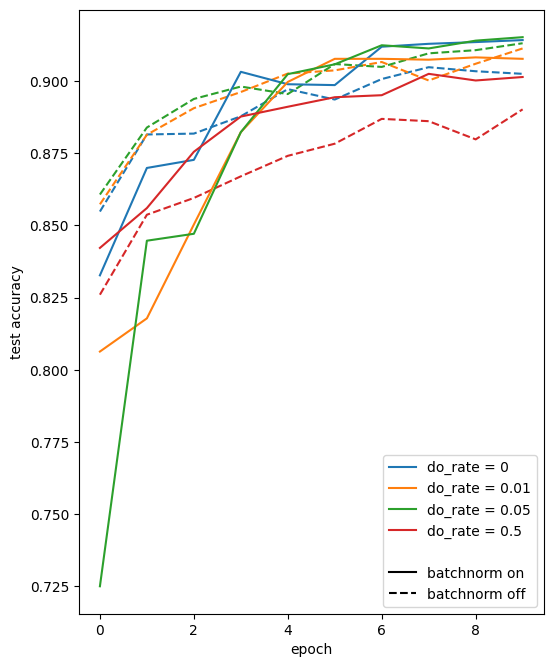

In [54]:
plt.figure(figsize=(6, 8), dpi=100)
color_cycle = iter(plt.rcParams['axes.prop_cycle'])

colors = {}

lines = []
labels = []
for config, model in models.items():
  config = eval(config)
  if config['dropout_rate'] not in colors:
    colors[config['dropout_rate']] = next(color_cycle)

  color = colors[config['dropout_rate']]['color']

  style = '-' if config['use_batchnorm'] else '--'
  line, = plt.plot(model.history.history['val_sparse_categorical_accuracy'], style,
                   c=color)
  
  if config['use_batchnorm']:
    lines.append(line)
    labels.append(f"do_rate = {config['dropout_rate']}")

plt.xlabel("epoch")
plt.ylabel("test accuracy");

from matplotlib.lines import Line2D

lines += [Line2D([0], [0], linestyle='-', color='w'),
          Line2D([0], [0], linestyle='-', color='k'),
          Line2D([0], [0], linestyle='--', color='k')]
labels += ['', 'batchnorm on', 'batchnorm off']
plt.legend(lines, labels);


**1**
I should place batchnorm after the activation function because if we were to put a activation after batch norm, then the batch norm layer cannot fully control the statistics of the input going into the next layer since the output of the batch norm layer has to go through an activation. 

**2**
Dropout is meant to block information from certain neurons completely to make sure the neurons do not co-adapt. So, the batch normalization has to be after dropout otherwise you are passing information through normalization statistics.

**3**
In this case we need activation function in the output layer e.g. softmax, because softmax used as the activation function for multi-class classification problems (as it is) where class membership is required on more than two class labels.

**4**
We do not have to add Dropout in the output layer